In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import gc



Installments Payments duplicated rows: 0
Previous Application duplicated rows: 0


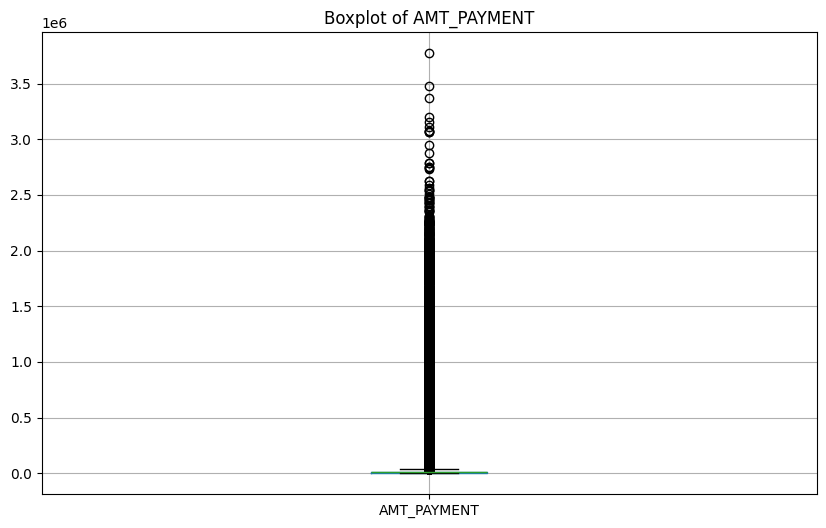

Installments Payments and Previous Application features saved.


In [ ]:

# STEP 1: LOAD DATA
installments_payments = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/installments_payments.csv')
previous_application = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/previous_application.csv')

# STEP 2: LOẠI BỎ DỮ LIỆU TRÙNG LẶP
print("Installments Payments duplicated rows:", installments_payments.duplicated().sum())
installments_payments = installments_payments.drop_duplicates()

print("Previous Application duplicated rows:", previous_application.duplicated().sum())
previous_application = previous_application.drop_duplicates()

# STEP 3: XỬ LÝ GIÁ TRỊ THIẾU
# Installments Payments
installments_payments['AMT_PAYMENT'] = installments_payments['AMT_PAYMENT'].fillna(0)
installments_payments['DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'].fillna(installments_payments['DAYS_INSTALMENT'])

# Previous Application
previous_application['AMT_APPLICATION'] = previous_application['AMT_APPLICATION'].fillna(0)
previous_application['AMT_CREDIT'] = previous_application['AMT_CREDIT'].fillna(0)

# Điền các giá trị thiếu còn lại bằng 0
installments_payments = installments_payments.fillna(0)
previous_application = previous_application.fillna(0)

# STEP 4: XỬ LÝ NGOẠI LỆ
# Kiểm tra ngoại lệ bằng boxplot
installments_payments.boxplot(column=['AMT_PAYMENT'], figsize=(10, 6))
plt.title('Boxplot of AMT_PAYMENT')
plt.show()

# Loại bỏ ngoại lệ dựa trên percentile
lower_bound = installments_payments['AMT_PAYMENT'].quantile(0.01)
upper_bound = installments_payments['AMT_PAYMENT'].quantile(0.99)
installments_payments = installments_payments[(installments_payments['AMT_PAYMENT'] >= lower_bound) &
                                              (installments_payments['AMT_PAYMENT'] <= upper_bound)]

# STEP 5: CHUẨN HÓA DỮ LIỆU
scaler = MinMaxScaler()
columns_to_scale = ['AMT_PAYMENT', 'AMT_INSTALMENT', 'DAYS_INSTALMENT']
installments_payments[columns_to_scale] = scaler.fit_transform(installments_payments[columns_to_scale])

# STEP 6: TẠO FEATURE TỪ INSTALLMENTS PAYMENTS
# Tổng số lần thanh toán trễ và thiếu
installments_payments['is_late'] = (installments_payments['DAYS_ENTRY_PAYMENT'] > installments_payments['DAYS_INSTALMENT']).astype(int)
installments_payments['is_less'] = (installments_payments['AMT_PAYMENT'] < installments_payments['AMT_INSTALMENT']).astype(int)

ip_total_late_times = installments_payments.groupby('SK_ID_CURR')['is_late'].sum()
ip_total_less_times = installments_payments.groupby('SK_ID_CURR')['is_less'].sum()

ip_total_late_days = installments_payments.loc[installments_payments['is_late'] == 1].groupby('SK_ID_CURR')['DAYS_ENTRY_PAYMENT'].sum()
ip_total_less_amount = installments_payments.loc[installments_payments['is_less'] == 1].groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

# Tổng số thanh toán thực tế và yêu cầu
ip_total_actual_payment = installments_payments.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()
ip_total_required_payment = installments_payments.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

# STEP 7: TẠO FEATURE TỪ PREVIOUS APPLICATION
# Tính tỷ lệ phê duyệt và từ chối
previous_application['APPROVED'] = (previous_application['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
previous_application['REJECTED'] = (previous_application['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)

approval_rate = previous_application.groupby('SK_ID_CURR')['APPROVED'].mean()
rejection_rate = previous_application.groupby('SK_ID_CURR')['REJECTED'].mean()

# STEP 8: TÍCH HỢP DỮ LIỆU
ip_feature = pd.DataFrame({
    'ip_total_late_times': ip_total_late_times,
    'ip_total_less_times': ip_total_less_times,
    'ip_total_late_days': ip_total_late_days,
    'ip_total_less_amount': ip_total_less_amount,
    'ip_total_actual_payment': ip_total_actual_payment,
    'ip_total_required_payment': ip_total_required_payment,
    'approval_rate': approval_rate,
    'rejection_rate': rejection_rate
}).reset_index()

# Điền giá trị thiếu còn lại bằng 0
ip_feature = ip_feature.fillna(0)

# STEP 9: LƯU DỮ LIỆU
ip_feature.to_csv('/content/drive/My Drive/group6_Final_DP/data/processed_data/ip_feature.csv', index=False)
print("Installments Payments and Previous Application features saved.")
